# Data Randomization Analysis for Function Approximation
This notebook demonstrates how data randomization affects the learning of surrogate models.
We use a simple quadratic function f(x) = (x-1000)² as our true function and try to approximate
it using a cubic polynomial Ψ(x) = θ₃x³ + θ₂x² + θ₁x + θ₀.

### The key aspects we investigate are:
1. Learning without data randomization (only matching function values)
2. Learning with data randomization (matching function values, derivatives, and promoting smoothness)
3. Comparative analysis of both approaches

In [25]:
# import tikzplotlib



Running analysis with 2 training points

Results With Data Randomization:
θ₀ = 9.999858e+05
θ₁ = -2.000547e+03
θ₂ = 1.001948e+00
θ₃ = -1.346073e-06

Results Without Data Randomization:
θ₀ = 0.000000e+00
θ₁ = 0.000000e+00
θ₂ = 0.000000e+00
θ₃ = 0.000000e+00

Predictions at x=500:
True value: 2.500000e+05
With data randomization: 2.500310e+05
Without data randomization: 0.000000e+00


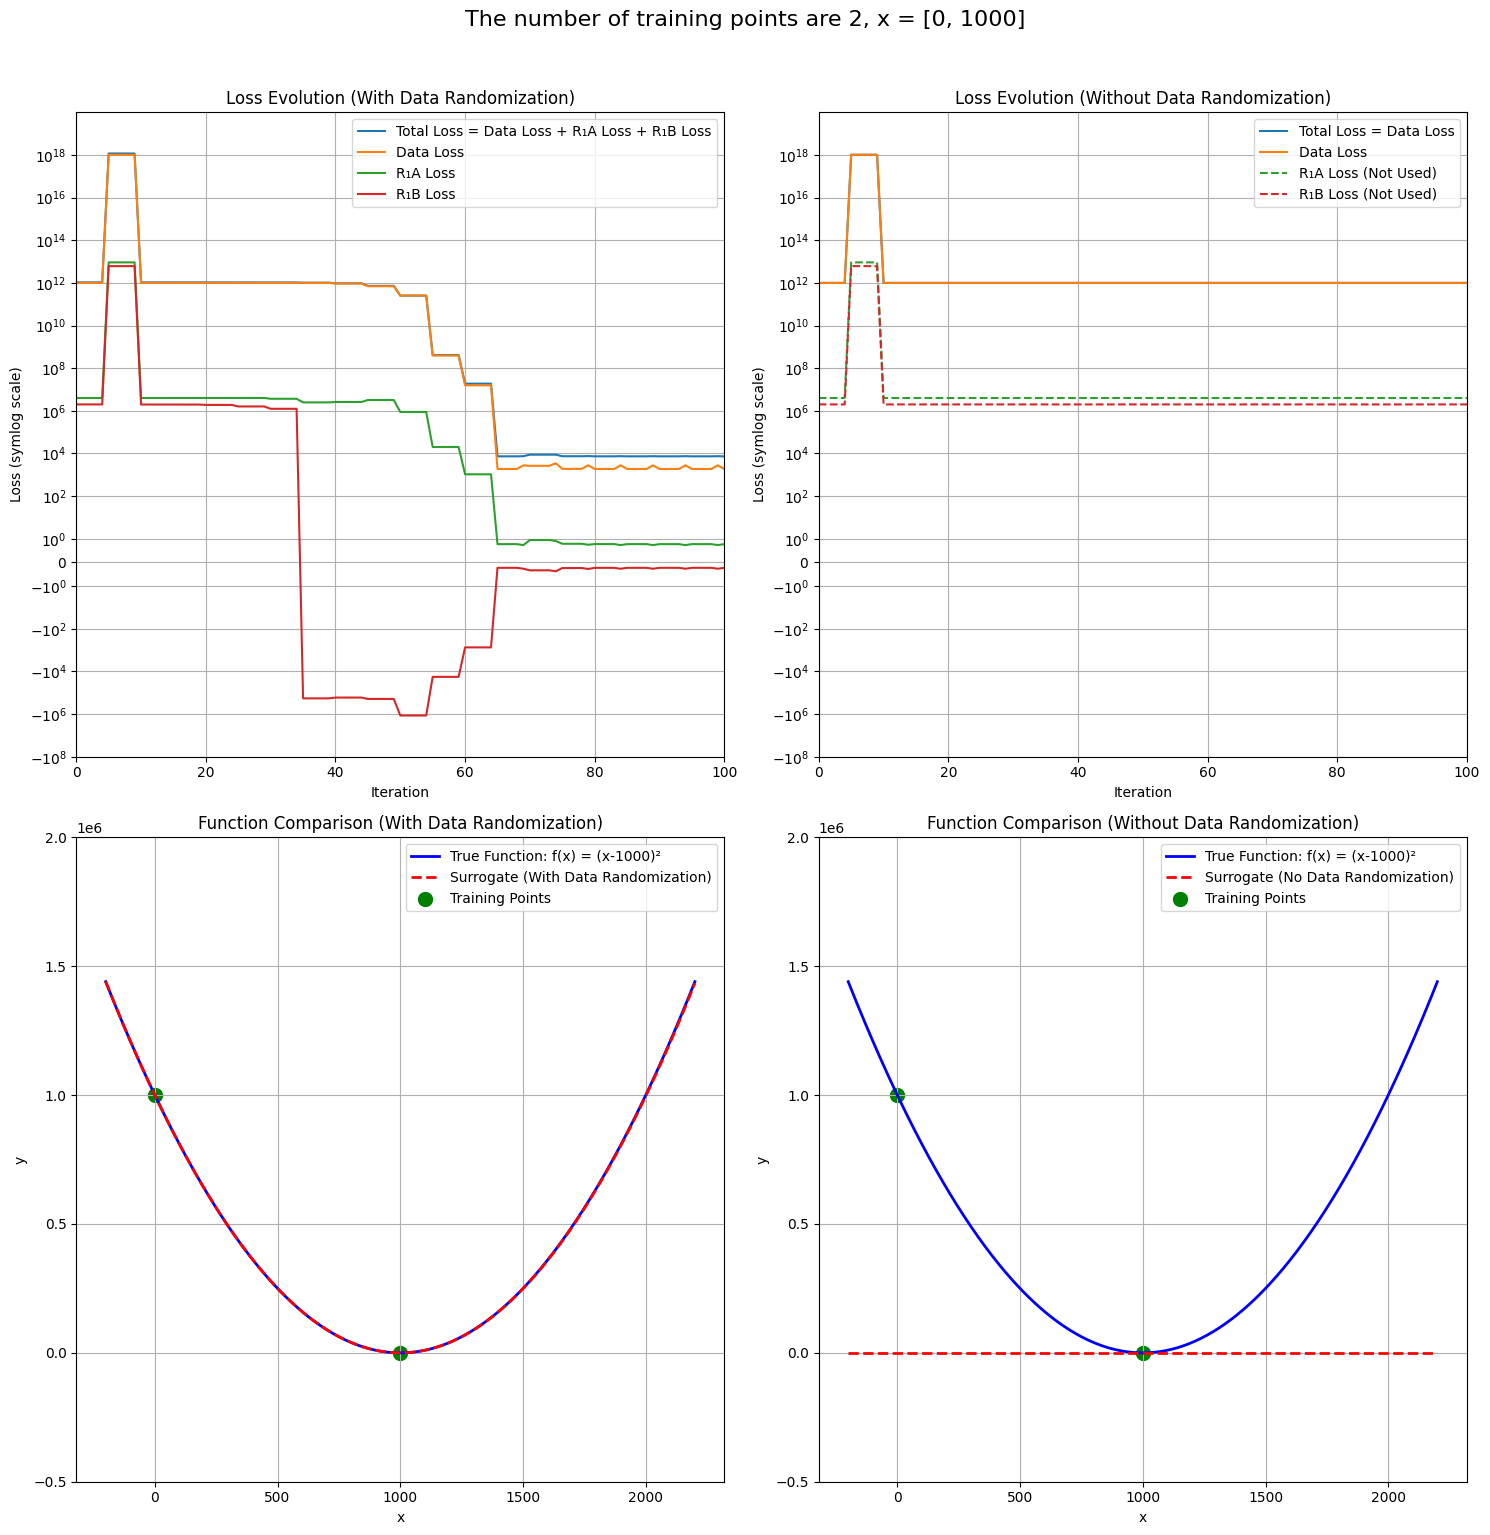


Running analysis with 3 training points

Results With Data Randomization:
θ₀ = 9.999733e+05
θ₁ = -2.000575e+03
θ₂ = 1.001884e+00
θ₃ = -1.256185e-06

Results Without Data Randomization:
θ₀ = 1.002228e+06
θ₁ = -3.753226e+04
θ₂ = 1.076011e+02
θ₃ = -7.107456e-02

Predictions at x=500:
True value: 2.500000e+05
With data randomization: 2.500000e+05
Without data randomization: 2.520645e+05


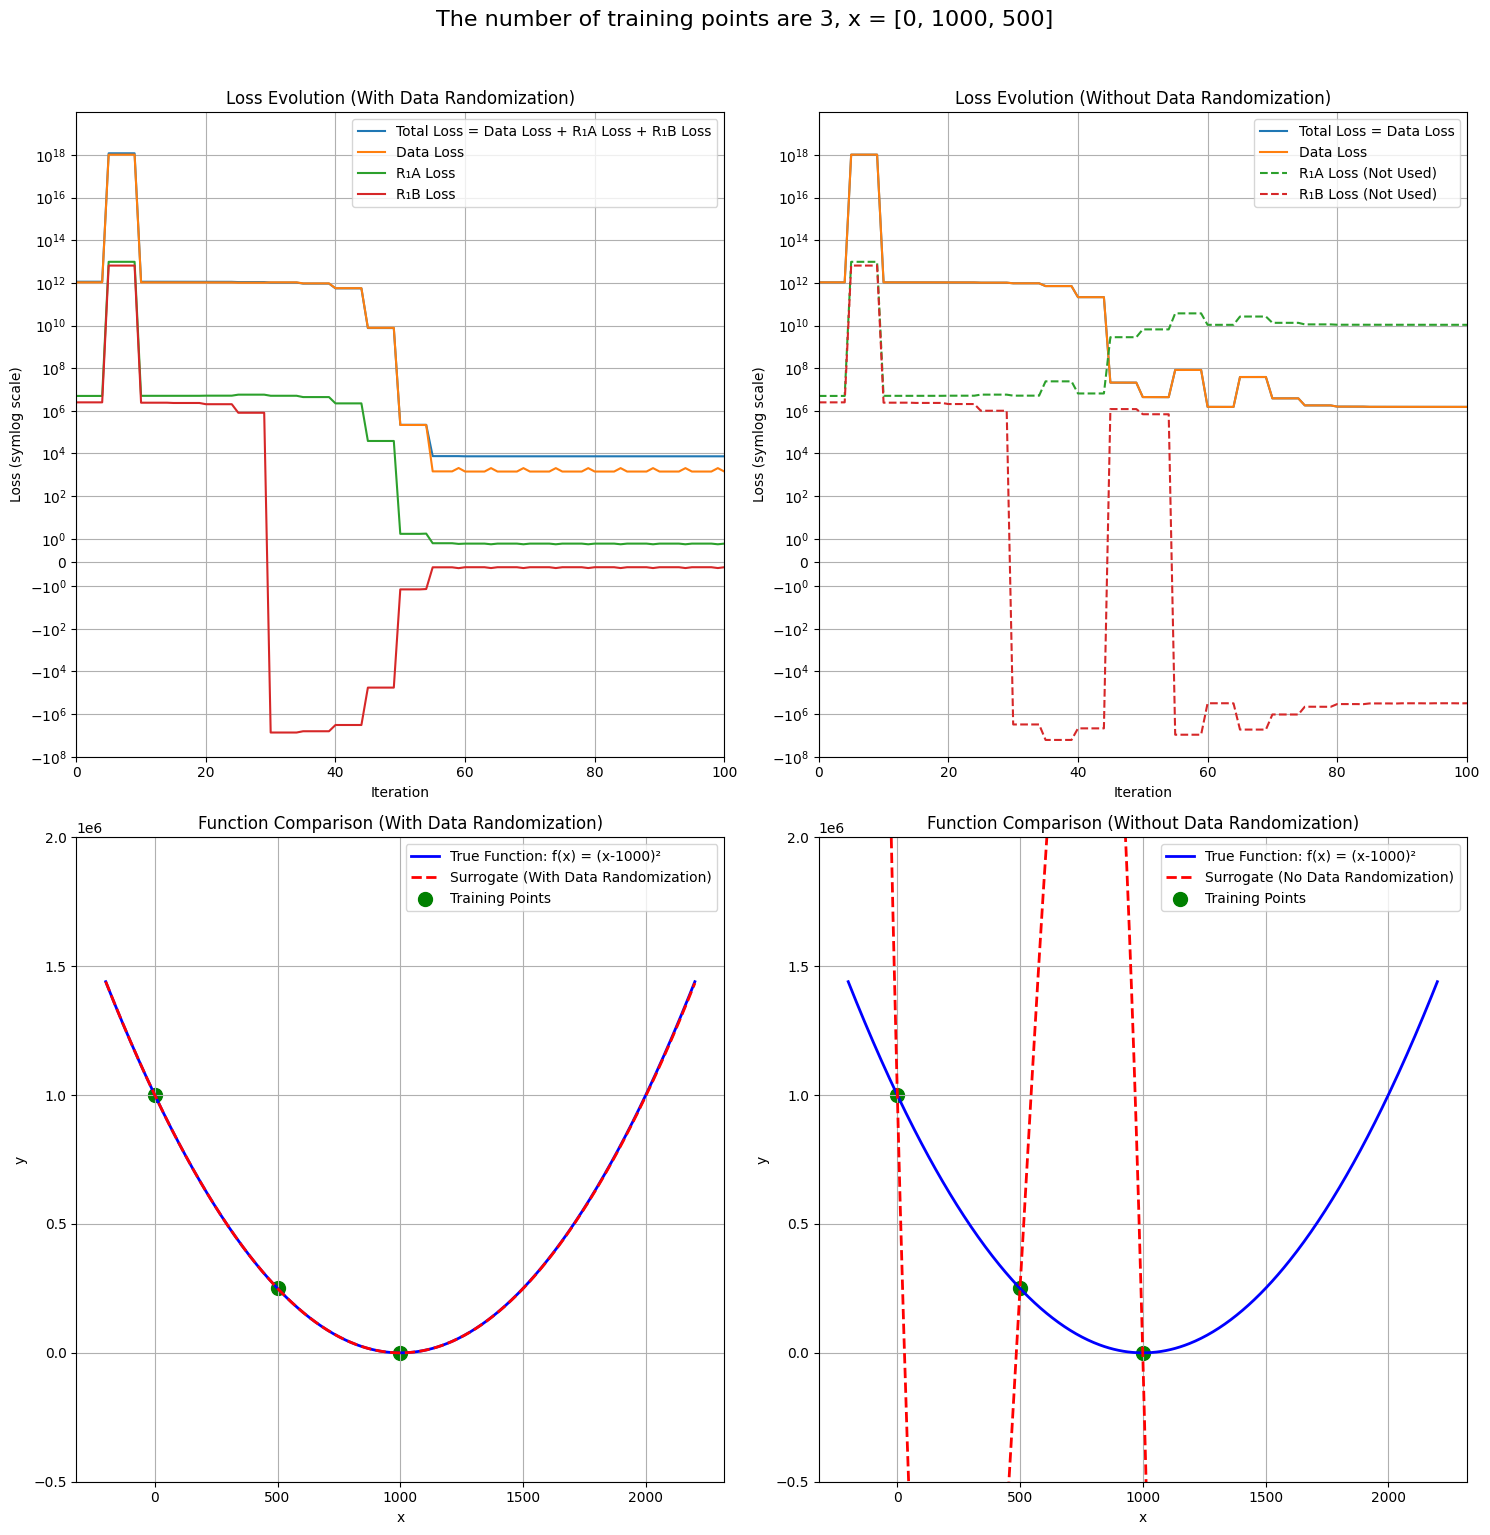


Running analysis with 4 training points

Results With Data Randomization:
θ₀ = 1.000007e+06
θ₁ = -2.001357e+03
θ₂ = 1.002696e+00
θ₃ = -1.198153e-06

Results Without Data Randomization:
θ₀ = 1.000083e+06
θ₁ = -2.002588e+03
θ₂ = 1.004957e+00
θ₃ = -2.203066e-06

Predictions at x=500:
True value: 2.500000e+05
With data randomization: 2.498526e+05
Without data randomization: 2.497522e+05


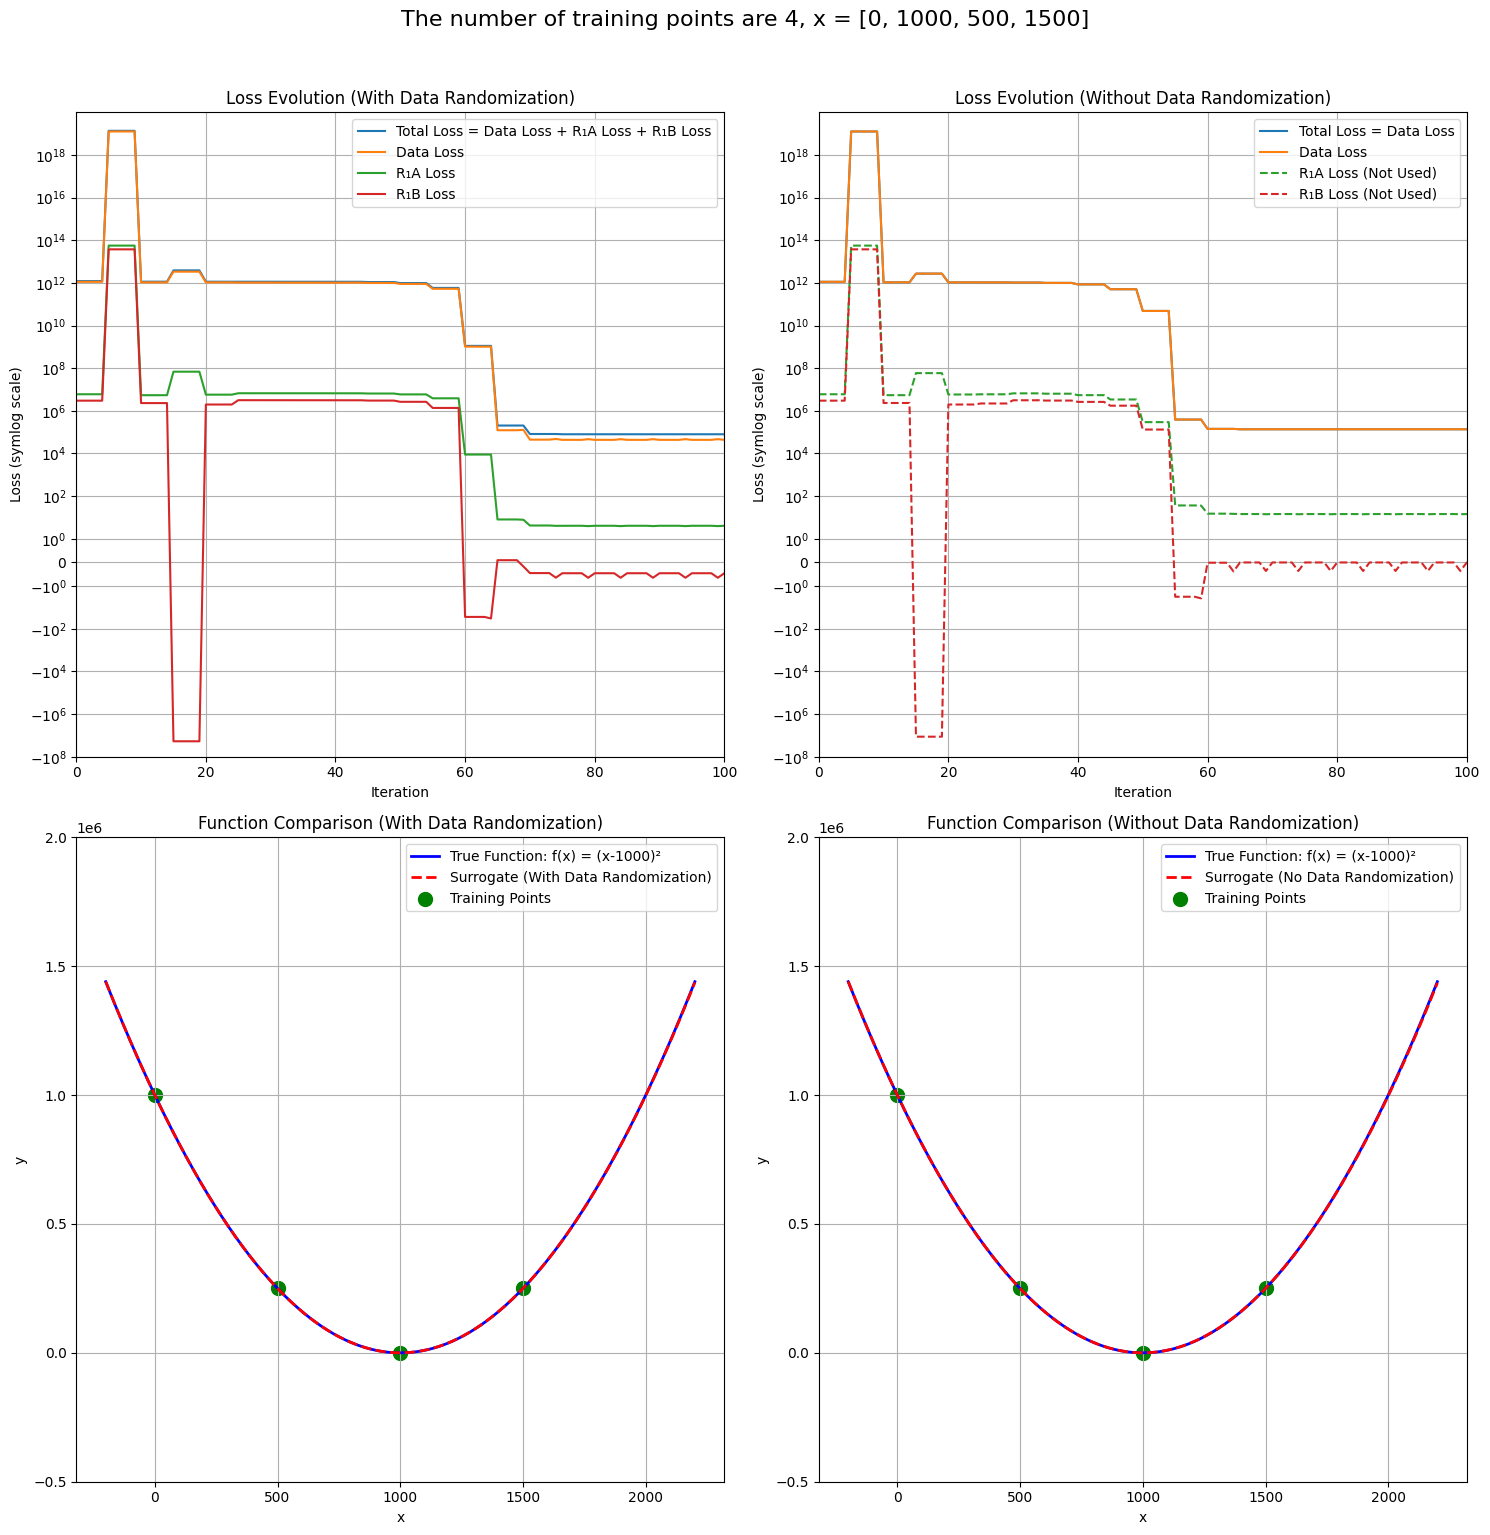

In [26]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

class ComparativeOptimization:
    def __init__(self):
        # Create separate loss histories for both approaches
        self.random_loss_history = {
            'total_loss': [],
            'original_loss': [],
            'R1A_loss': [],
            'R1B_loss': []
        }
        
        self.no_random_loss_history = {
            'total_loss': [],
            'original_loss': [],
            'R1A_loss': [],
            'R1B_loss': []
        }
        
        # Create figure with subplots for comparison
        self.fig, ((self.ax1, self.ax2), (self.ax3, self.ax4)) = plt.subplots(2, 2, figsize=(15, 15))
        
    def true_function(self, x):
        """The true function f(x) = (x-1000)^2"""
        return (x - 1000.0) ** 2

    def surrogate_model(self, x, theta):
        """Surrogate model Ψ(x) = θ₃x³ + θ₂x² + θ₁x + θ₀"""
        # Convert to float64 for better precision
        x = np.float64(x)
        theta = np.float64(theta)
        return theta[3] * x**3 + theta[2] * x**2 + theta[1] * x + theta[0]

    def surrogate_derivative(self, x, theta):
        """First derivative of surrogate model"""
        x = np.float64(x)
        theta = np.float64(theta)
        return 3 * theta[3] * x**2 + 2 * theta[2] * x + theta[1]

    def surrogate_second_derivative(self, x, theta):
        """Second derivative of surrogate model"""
        x = np.float64(x)
        theta = np.float64(theta)
        return 6 * theta[3] * x + 2 * theta[2]

    def true_derivative(self, x):
        """First derivative of true function"""
        return 2.0 * (x - 1000.0)

    def true_second_derivative(self, x):
        """Second derivative of true function"""
        return 2.0

    def calculate_loss_components(self, theta, include_data_randomization=True):
        """Calculate loss components with option for regularization"""
        
        
        # Original loss term with scaling
        original_loss = 0.0
        for x in x_points:
            diff = self.true_function(x) - self.surrogate_model(x, theta)
            original_loss += diff * diff
        
        # R₁A term (first derivative matching)
        R1A_loss = 0.0
        for x in x_points:
            diff = self.true_derivative(x) - self.surrogate_derivative(x, theta)
            R1A_loss += diff * diff
        
        # R₁B term (second derivative and function difference)
        R1B_loss = 0.0
        for x in x_points:
            second_deriv_diff = self.true_second_derivative(x) - self.surrogate_second_derivative(x, theta)
            func_diff = self.true_function(x) - self.surrogate_model(x, theta)
            R1B_loss += second_deriv_diff * func_diff
        
        # Total loss depends on whether we include regularization
        if include_data_randomization:
            # Regularization scaling factor
            Regularization_scale_factor = 10000.0
            
            total_loss = original_loss + Regularization_scale_factor * (R1A_loss + R1B_loss)
        else:
            total_loss = original_loss
        
        return total_loss, original_loss, R1A_loss, R1B_loss

    def loss_function(self, theta, include_data_randomization=True):
        """Unified loss function with regularization flag"""
        total_loss, original_loss, R1A_loss, R1B_loss = self.calculate_loss_components(theta, include_data_randomization)
        
        # Store values in appropriate history
        history = self.random_loss_history if include_data_randomization else self.no_random_loss_history
        history['total_loss'].append(float(total_loss))
        history['original_loss'].append(float(original_loss))
        history['R1A_loss'].append(float(R1A_loss))
        history['R1B_loss'].append(float(R1B_loss))
        
        return float(total_loss)

    def plot_comparative_results(self, theta_random, theta_no_random):
        """Plot comparative results for both approaches"""
        # Clear all plots
        for ax in [self.ax1, self.ax2, self.ax3, self.ax4]:
            ax.clear()
        
        # Plot 1: Loss History with Randomization
        iterations = range(len(self.random_loss_history['total_loss']))
        self.ax1.set_yscale('symlog', linthresh=1)
        self.ax1.plot(iterations, self.random_loss_history['total_loss'], 
                label='Total Loss = Data Loss + R₁A Loss + R₁B Loss')
        self.ax1.plot(iterations, self.random_loss_history['original_loss'], 
                label='Data Loss')
        self.ax1.plot(iterations, self.random_loss_history['R1A_loss'], 
                label='R₁A Loss')
        self.ax1.plot(iterations, self.random_loss_history['R1B_loss'], 
                label='R₁B Loss')
        self.ax1.set_title('Loss Evolution (With Data Randomization)')
        self.ax1.set_xlabel('Iteration')
        self.ax1.set_ylabel('Loss (symlog scale)')
        self.ax1.legend()
        self.ax1.grid(True)
        self.ax1.set_ylim(-1e8, 1e20)
        self.ax1.set_xlim(0, 100)

        # Plot 2: Loss History without Randomization
        iterations = range(len(self.no_random_loss_history['total_loss']))
        self.ax2.set_yscale('symlog', linthresh=1)
        self.ax2.plot(iterations, self.no_random_loss_history['total_loss'], 
                label='Total Loss = Data Loss')
        self.ax2.plot(iterations, self.no_random_loss_history['original_loss'], 
                label='Data Loss')
        self.ax2.plot(iterations, self.no_random_loss_history['R1A_loss'], '--', 
                label='R₁A Loss (Not Used)')
        self.ax2.plot(iterations, self.no_random_loss_history['R1B_loss'], '--', 
                label='R₁B Loss (Not Used)')
        self.ax2.set_title('Loss Evolution (Without Data Randomization)')
        self.ax2.set_xlabel('Iteration')
        self.ax2.set_ylabel('Loss (symlog scale)')
        self.ax2.legend()
        self.ax2.grid(True)
        self.ax2.set_ylim(-1e8, 1e20)
        self.ax2.set_xlim(0, 100)
        
        # Plot 3 & 4: Function Comparisons
        x_range = np.linspace(-200, 2200, 500)  # Adjusted range for x=1000
        true_values = [self.true_function(x) for x in x_range]
        surrogate_values_random = [self.surrogate_model(x, theta_random) for x in x_range]
        surrogate_values_no_random = [self.surrogate_model(x, theta_no_random) for x in x_range]
        
        # With Randomization
        self.ax3.plot(x_range, true_values, 'b-', label='True Function: f(x) = (x-1000)²', linewidth=2)
        self.ax3.plot(x_range, surrogate_values_random, 'r--', label='Surrogate (With Data Randomization)', linewidth=2)
        y_points = [self.true_function(x) for x in x_points]
        self.ax3.scatter(x_points, y_points, color='green', s=100, label='Training Points')
        self.ax3.set_title('Function Comparison (With Data Randomization)')
        self.ax3.set_xlabel('x')
        self.ax3.set_ylabel('y')
        self.ax3.set_ylim(-0.5e6, 2e6)
        self.ax3.legend()
        self.ax3.grid(True)
        
        # Without Randomization
        self.ax4.plot(x_range, true_values, 'b-', label='True Function: f(x) = (x-1000)²', linewidth=2)
        self.ax4.plot(x_range, surrogate_values_no_random, 'r--', label='Surrogate (No Data Randomization)', linewidth=2)
        self.ax4.scatter(x_points, y_points, color='green', s=100, label='Training Points')
        self.ax4.set_title('Function Comparison (Without Data Randomization)')
        self.ax4.set_xlabel('x')
        self.ax4.set_ylabel('y')
        self.ax4.set_ylim(-0.5e6, 2e6)
        self.ax4.legend()
        self.ax4.grid(True)
        
        # Add main title showing number of training points
        self.fig.suptitle(f'The number of training points are {len(x_points)}, x = {x_points.astype(int).tolist()}', 
                         fontsize=16, y=1.02)
        
        plt.tight_layout()
        plt.show()

    def run_comparative_analysis(self):
        """Run optimization with and without randomization and compare results"""
        # Clear previous histories
        for history in [self.random_loss_history, self.no_random_loss_history]:
            for key in history:
                history[key] = []
        
        # Initial guess for both approaches
        theta_init = np.zeros(4, dtype=np.float64)
        
        # Enhanced optimization options for better convergence
        options = {
            'maxiter': 1000,    # Significantly increased maximum iterations
            'gtol': 1e-16,     # Gradient tolerance (even tighter)
            'eps': 1e-8,       # Step size for numerical gradient approximation
        }
        
        # Optimize with randomization
        result_random = minimize(lambda theta: self.loss_function(theta, True), 
                               theta_init, method='BFGS', options=options)
        theta_random = result_random.x
        
        # Optimize without randomization
        result_no_random = minimize(lambda theta: self.loss_function(theta, False), 
                                  theta_init, method='BFGS', options=options)
        theta_no_random = result_no_random.x
        
        # Print comparative results
        print("\nResults With Data Randomization:")
        print(f"θ₀ = {theta_random[0]:.6e}")
        print(f"θ₁ = {theta_random[1]:.6e}")
        print(f"θ₂ = {theta_random[2]:.6e}")
        print(f"θ₃ = {theta_random[3]:.6e}")
        
        print("\nResults Without Data Randomization:")
        print(f"θ₀ = {theta_no_random[0]:.6e}")
        print(f"θ₁ = {theta_no_random[1]:.6e}")
        print(f"θ₂ = {theta_no_random[2]:.6e}")
        print(f"θ₃ = {theta_no_random[3]:.6e}")
        
        # Test predictions at unseen point
        x_test = 500.0  # Midpoint between 0 and 1000
        true_value = self.true_function(x_test)
        pred_random = self.surrogate_model(x_test, theta_random)
        pred_no_random = self.surrogate_model(x_test, theta_no_random)
        
        print(f"\nPredictions at x=500:")
        print(f"True value: {true_value:.6e}")
        print(f"With data randomization: {pred_random:.6e}")
        print(f"Without data randomization: {pred_no_random:.6e}")
        
        # Plot comparative results
        self.plot_comparative_results(theta_random, theta_no_random)
        
        return theta_random, theta_no_random

# Define the full set of points
all_points = np.array([0, 1000, 500, 1500], dtype=np.float64)

def run_analysis_for_n_points(n_points):
    """Run the analysis with a specific number of points"""
    global x_points  # We'll modify the global x_points
    x_points = all_points[:n_points]  # Take first n points
    
    optimizer = ComparativeOptimization()
    theta_random, theta_no_random = optimizer.run_comparative_analysis()
    plt.close()  # Close the figure to free memory
    return theta_random, theta_no_random

# Main execution
if __name__ == "__main__":
    # Loop through different numbers of points (2 to 4)
    for n in range(2, 5):
        print(f"\n{'='*50}")
        print(f"Running analysis with {n} training points")
        print(f"{'='*50}")
        theta_random, theta_no_random = run_analysis_for_n_points(n)


Running analysis with 4 training points

Results With Data Randomization:
θ₍0₎ = 1.000007e+06
θ₍1₎ = -2.001357e+03
θ₍2₎ = 1.002696e+00
θ₍3₎ = -1.198153e-06

Results Without Data Randomization:
θ₍0₎ = 1.000083e+06
θ₍1₎ = -2.002588e+03
θ₍2₎ = 1.004957e+00
θ₍3₎ = -2.203066e-06

Predictions at x=500.0:
True value: 2.500000e+05
With data randomization: 2.498526e+05
Without data randomization: 2.497522e+05


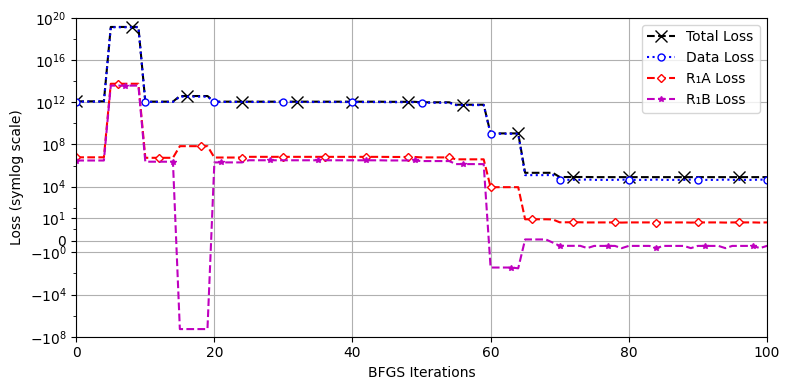

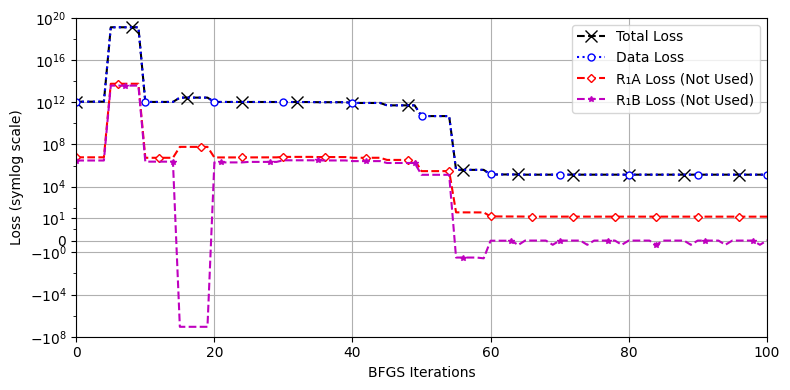

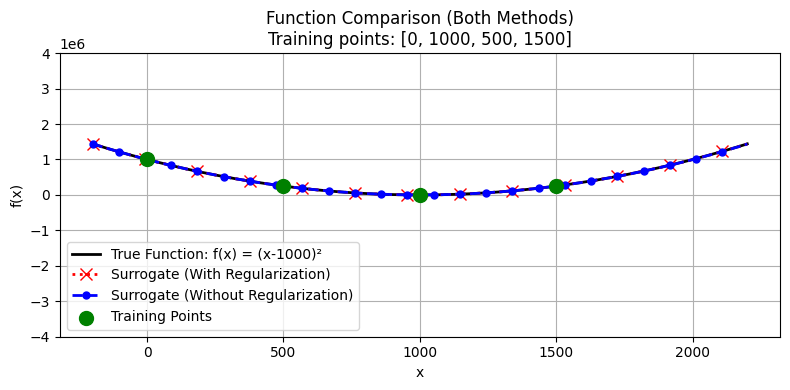

In [27]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

class ComparativeOptimization:
    def __init__(self):
        # Create separate loss histories for both approaches
        self.random_loss_history = {
            'total_loss': [],
            'original_loss': [],
            'R1A_loss': [],
            'R1B_loss': []
        }
        
        self.no_random_loss_history = {
            'total_loss': [],
            'original_loss': [],
            'R1A_loss': [],
            'R1B_loss': []
        }
        
    def true_function(self, x):
        """The true function f(x) = (x-1000)^2"""
        return (x - 1000.0) ** 2

    def surrogate_model(self, x, theta):
        """Surrogate model Ψ(x) = θ₃x³ + θ₂x² + θ₁x + θ₀"""
        x = np.float64(x)
        theta = np.float64(theta)
        return theta[3] * x**3 + theta[2] * x**2 + theta[1] * x + theta[0]

    def surrogate_derivative(self, x, theta):
        """First derivative of surrogate model"""
        x = np.float64(x)
        theta = np.float64(theta)
        return 3 * theta[3] * x**2 + 2 * theta[2] * x + theta[1]

    def surrogate_second_derivative(self, x, theta):
        """Second derivative of surrogate model"""
        x = np.float64(x)
        theta = np.float64(theta)
        return 6 * theta[3] * x + 2 * theta[2]

    def true_derivative(self, x):
        """First derivative of true function"""
        return 2.0 * (x - 1000.0)

    def true_second_derivative(self, x):
        """Second derivative of true function"""
        return 2.0

    def calculate_loss_components(self, theta, x_points, include_data_randomization=True):
        """Calculate loss components with option for regularization"""
        # Original loss term
        original_loss = np.sum([(self.true_function(x) - self.surrogate_model(x, theta))**2 for x in x_points])
        
        # R₁A term (first derivative matching)
        R1A_loss = np.sum([(self.true_derivative(x) - self.surrogate_derivative(x, theta))**2 for x in x_points])
        
        # R₁B term (second derivative and function difference)
        R1B_loss = np.sum([
            (self.true_second_derivative(x) - self.surrogate_second_derivative(x, theta)) *
            (self.true_function(x) - self.surrogate_model(x, theta))
            for x in x_points
        ])
        
        # Total loss with regularization
        if include_data_randomization:
            Regularization_scale_factor = 1e4  # 10000.0
            total_loss = original_loss + Regularization_scale_factor * (R1A_loss + R1B_loss)
        else:
            total_loss = original_loss
        
        return total_loss, original_loss, R1A_loss, R1B_loss

    def loss_function(self, theta, x_points, include_data_randomization=True):
        """Unified loss function with regularization flag"""
        total_loss, original_loss, R1A_loss, R1B_loss = self.calculate_loss_components(
            theta, x_points, include_data_randomization
        )
        
        # Store values in appropriate history
        history = self.random_loss_history if include_data_randomization else self.no_random_loss_history
        history['total_loss'].append(float(total_loss))
        history['original_loss'].append(float(original_loss))
        history['R1A_loss'].append(float(R1A_loss))
        history['R1B_loss'].append(float(R1B_loss))
        
        return float(total_loss)

    def plot_loss_history(self, include_data_randomization=True):
        """Plot loss history for optimization"""
        history = self.random_loss_history if include_data_randomization else self.no_random_loss_history
        
        fig, ax = plt.subplots(figsize=(8, 4))
        iterations = range(len(history['total_loss']))
        
        # Set symmetric log scale
        ax.set_yscale('symlog', linthresh=1)  # Linear threshold near zero
        
        # Plot the data
        ax.plot(iterations, history['total_loss'], 'k--', label='Total Loss', marker = 'x', markevery = 8, ms = 8)
        ax.plot(iterations, history['original_loss'], 'b:', label='Data Loss', marker = 'o', markevery = 10, ms = 5, mfc = 'white')
        
        if include_data_randomization:
            ax.plot(iterations, history['R1A_loss'], 'r--', label='R₁A Loss', marker = 'D', markevery = 6, ms = 4, mfc = 'white')
            ax.plot(iterations, history['R1B_loss'], 'm--', label='R₁B Loss', marker = '*', markevery = 7, ms = 4)
        else:
            ax.plot(iterations, history['R1A_loss'], 'r--', label='R₁A Loss (Not Used)', marker = 'D', markevery = 6, ms = 4, mfc = 'white')
            ax.plot(iterations, history['R1B_loss'], 'm--', label='R₁B Loss (Not Used)', marker = '*', markevery = 7, ms = 4)
        
        # plt.title(f'Loss Evolution {"(With" if include_data_randomization else "(Without"} Data Randomization)')
        plt.xlabel('BFGS Iterations')
        plt.ylabel('Loss (symlog scale)')
        plt.legend()
        plt.ylim(-1e8, 1e20)
        plt.yticks([-1e8, -1e4, -1, 0, 1e1, 1e4, 1e8, 1e12, 1e16, 1e20],)
        plt.xlim(0, 100)
        plt.tight_layout()
        plt.grid(True)

        # if include_data_randomization:
        #     tikzplotlib.save(f"/work2/08171/nvhai/ls6/JAX_GNN_DG/Latex_report_paper/Graph_Network_DG_paper/Figs/1D_test_example/loss_reg_{n_point}.tex")
        
    def plot_merged_comparison(self, theta_random, theta_no_random, x_points):
        """Plot merged function comparison showing both surrogate models"""
        plt.figure(figsize=(8, 4))
        x_range = np.linspace(-200, 2200, 500)
        
        # Calculate values for all functions
        true_values = [self.true_function(x) for x in x_range]
        surrogate_values_random = [self.surrogate_model(x, theta_random) for x in x_range]
        surrogate_values_no_random = [self.surrogate_model(x, theta_no_random) for x in x_range]
        
        # Plot true function and both surrogate models
        plt.plot(x_range, true_values, 'k-', label='True Function: f(x) = (x-1000)²', linewidth=2)
        plt.plot(x_range, surrogate_values_random, 'r:', label='Surrogate (With Regularization)', linewidth=2, marker = 'x', markevery = 40, ms = 8)
        plt.plot(x_range, surrogate_values_no_random, 'b--', label='Surrogate (Without Regularization)', linewidth=2, marker = 'o', markevery = 20, ms = 5)
        
        # Plot training points
        y_points = [self.true_function(x) for x in x_points]
        plt.scatter(x_points, y_points, color='g', s=100, label='Training Points', zorder=5)
        
        plt.title('Function Comparison (Both Methods)\n'
                 f'Training points: {x_points.astype(int).tolist()}')
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.ylim(-4e6, 4e6)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def run_comparative_analysis(self, x_points):
        """Run optimization with and without randomization and compare results"""
        # Clear previous histories
        for history in [self.random_loss_history, self.no_random_loss_history]:
            for key in history:
                history[key] = []
        
        # Initial guess for both approaches
        theta_init = np.zeros(4, dtype=np.float64)
        
        # Enhanced optimization options
        options = {
            'maxiter': 1000,
            'gtol': 1e-16,
            'eps': 1e-8,
        }
        
        # Optimize with randomization
        result_random = minimize(
            lambda theta: self.loss_function(theta, x_points, True), 
            theta_init, 
            method='BFGS', 
            options=options
        )
        theta_random = result_random.x
        
        # Optimize without randomization
        result_no_random = minimize(
            lambda theta: self.loss_function(theta, x_points, False), 
            theta_init, 
            method='BFGS', 
            options=options
        )
        theta_no_random = result_no_random.x
        
        # Print results
        print("\nResults With Data Randomization:")
        for i, theta in enumerate(theta_random):
            print(f"θ₍{i}₎ = {theta:.6e}")
        
        print("\nResults Without Data Randomization:")
        for i, theta in enumerate(theta_no_random):
            print(f"θ₍{i}₎ = {theta:.6e}")
        
        # Test predictions at unseen point
        x_test = 500.0
        true_value = self.true_function(x_test)
        pred_random = self.surrogate_model(x_test, theta_random)
        pred_no_random = self.surrogate_model(x_test, theta_no_random)
        
        print(f"\nPredictions at x={x_test}:")
        print(f"True value: {true_value:.6e}")
        print(f"With data randomization: {pred_random:.6e}")
        print(f"Without data randomization: {pred_no_random:.6e}")
        
        # Plot results
        self.plot_loss_history(True)
        self.plot_loss_history(False)
        self.plot_merged_comparison(theta_random, theta_no_random, x_points)
        
        return theta_random, theta_no_random

def run_analysis_for_n_points(n_points):
    """Run the analysis with a specific number of points"""
    # Define points
    all_points = np.array([0, 1000, 500, 1500], dtype=np.float64)
    x_points = all_points[:n_points]
    
    optimizer = ComparativeOptimization()
    theta_random, theta_no_random = optimizer.run_comparative_analysis(x_points)
    plt.close('all')  # Close all figures to free memory
    return theta_random, theta_no_random

if __name__ == "__main__":
    # Loop through different numbers of points (2 to 4)
    n_point = 4
    for n in range(n_point, n_point+1):
        print(f"\n{'='*50}")
        print(f"Running analysis with {n} training points")
        print(f"{'='*50}")
        theta_random, theta_no_random = run_analysis_for_n_points(n)